In [1]:
# Import findspark and initialize. 
import findspark
findspark.init()

In [2]:
# Import packages
from pyspark.sql import SparkSession
import time

# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/03 14:27:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# 1. Read in the AWS S3 bucket into a DataFrame.
from pyspark import SparkFiles
url = "https://groupfourproject.s3.ca-central-1.amazonaws.com/bank_churners.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("bank_churners.csv"), sep=",", header=True, ignoreLeadingWhiteSpace=True)
df.show()


+---------+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+----------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------+
|CLIENTNUM|   Attrition_Flag|Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|Naive_Bayes_Classifier_Attrit

In [4]:
import pandas as pd
pandas_df = df.toPandas()
pandas_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype 
---  ------                                                                                                                              --------------  ----- 
 0   CLIENTNUM                                                                                                                           10127 non-null  object
 1   Attrition_Flag                                                                                                                      10127 non-null  object
 2   Customer_Age                                                                                                                        10127 non-null  object
 3   Gender                                                                                

In [5]:
pandas_df.select_dtypes(include="object").nunique()

CLIENTNUM                                                                                                                             10127
Attrition_Flag                                                                                                                            2
Customer_Age                                                                                                                             45
Gender                                                                                                                                    2
Dependent_count                                                                                                                           6
Education_Level                                                                                                                           7
Marital_Status                                                                                                                            4
Income_Category     

In [6]:
bank_df = pandas_df.drop(["Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1", "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2"], axis=1)

In [7]:
bank_df.describe().T

,count,unique,top,freq
CLIENTNUM,10127,10127,768805383,1
Attrition_Flag,10127,2,Existing Customer,8500
Customer_Age,10127,45,44,500
Gender,10127,2,F,5358
Dependent_count,10127,6,3,2732
Education_Level,10127,7,Graduate,3128
Marital_Status,10127,4,Married,4687
Income_Category,10127,6,Less than $40K,3561
Card_Category,10127,4,Blue,9436
Months_on_book,10127,44,36,2463


In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

In [9]:
data = bank_df.copy()

In [10]:
def summary(data: pd.DataFrame, x: str):
    # Ensure the column is numeric
    data[x] = pd.to_numeric(data[x], errors='coerce')
    
    # Drop NaN values resulting from conversion
    data = data.dropna(subset=[x])
    
    # 5 point summary
    x_min = data[x].min()
    x_max = data[x].max()
    Q1 = data[x].quantile(0.25)
    Q2 = data[x].quantile(0.50)
    Q3 = data[x].quantile(0.75)

    summary_dict = {"Min": x_min, "Q1": Q1, "Q2": Q2, "Q3": Q3, "Max": x_max}
    summary_df = pd.DataFrame(data=summary_dict, index=["Value"])
    print(f"5 Point Summary of {x.capitalize()} Attribute:\n")
    print(tabulate(summary_df, headers="keys", tablefmt="psql"))

    # Plotting
    fig = plt.figure(figsize=(16, 8))
    plt.subplots_adjust(hspace=0.6)
    sns.set_palette("Pastel1")

    # Histogram with mean and median
    plt.subplot(221, frameon=True)
    ax1 = sns.histplot(data[x], kde=True, color="purple")
    ax1.axvline(np.mean(data[x]), color="purple", linestyle="--", label='Mean')
    ax1.axvline(np.median(data[x]), color="black", linestyle="-", label='Median')
    plt.title(f"{x.capitalize()} Density Distribution")
    plt.legend()

    # Violin plot
    plt.subplot(222, frameon=True)
    ax2 = sns.violinplot(x=data[x], palette="Accent")
    plt.title(f"{x.capitalize()} Violinplot")

    # Box plot
    plt.subplot(223, frameon=True)
    ax3 = sns.boxplot(x=data[x], palette="cool", width=0.7, linewidth=0.6, showmeans=True)
    plt.title(f"{x.capitalize()} Boxplot")

    # Cumulative density distribution
    plt.subplot(224, frameon=True)
    ax4 = sns.kdeplot(data[x], cumulative=True)
    plt.title(f"{x.capitalize()} Cumulative Density Distribution")

    plt.show()

5 Point Summary of Customer_age Attribute:

+-------+-------+------+------+------+-------+
|       |   Min |   Q1 |   Q2 |   Q3 |   Max |
|-------+-------+------+------+------+-------|
| Value |    26 |   41 |   46 |   52 |    73 |
+-------+-------+------+------+------+-------+


/Users/chuchu/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chuchu/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


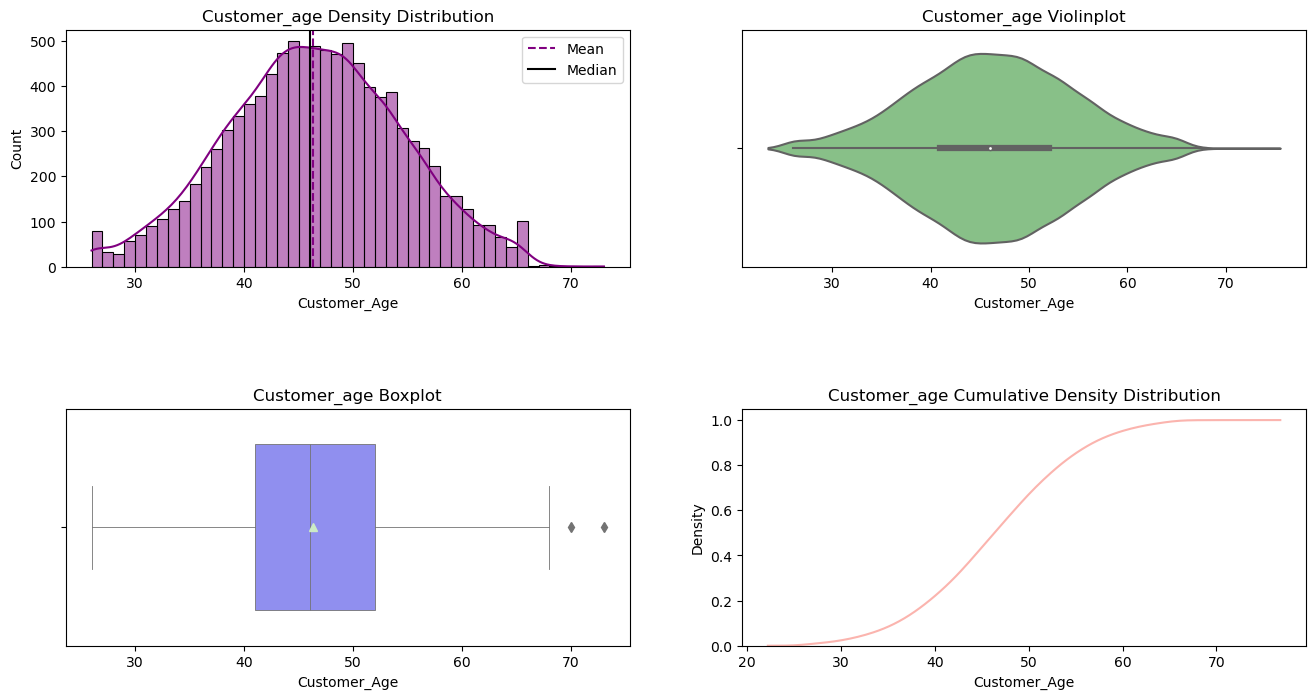

In [11]:
summary(data, "Customer_Age")

5 Point Summary of Dependent_count Attribute:

+-------+-------+------+------+------+-------+
|       |   Min |   Q1 |   Q2 |   Q3 |   Max |
|-------+-------+------+------+------+-------|
| Value |     0 |    1 |    2 |    3 |     5 |
+-------+-------+------+------+------+-------+


/Users/chuchu/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chuchu/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


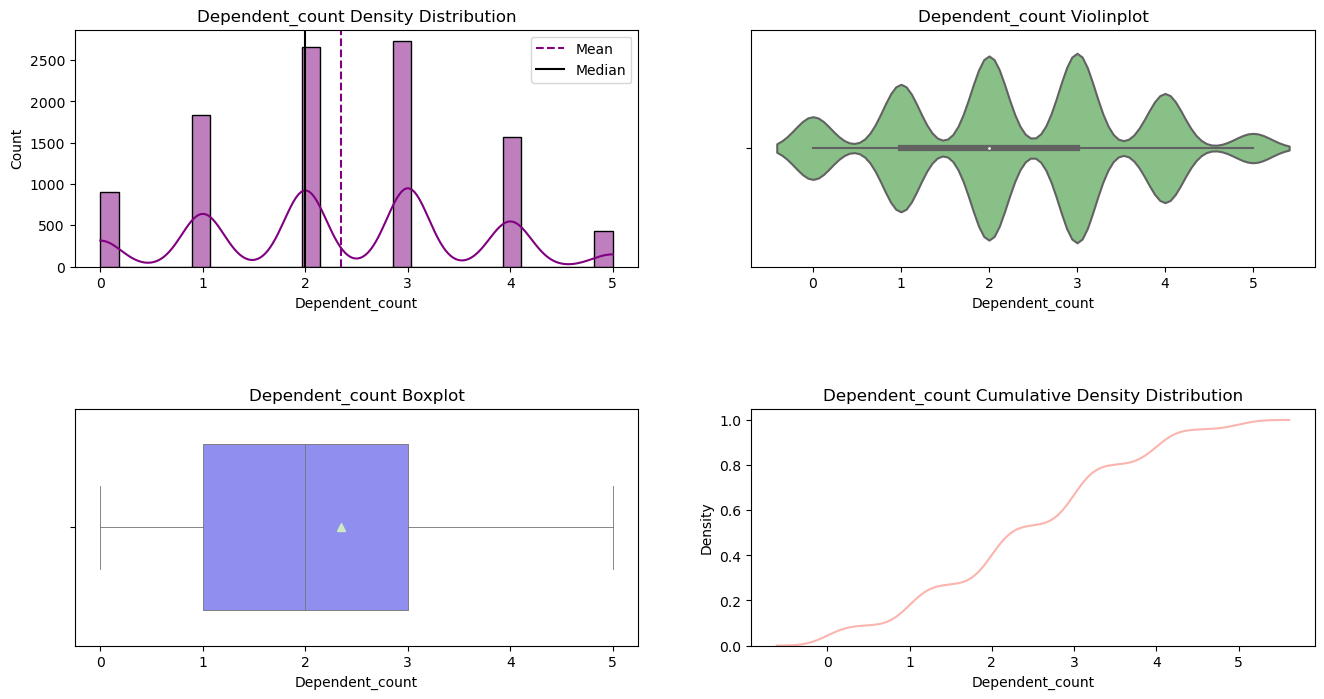

In [12]:
summary(data, "Dependent_count")

5 Point Summary of Months_on_book Attribute:

+-------+-------+------+------+------+-------+
|       |   Min |   Q1 |   Q2 |   Q3 |   Max |
|-------+-------+------+------+------+-------|
| Value |    13 |   31 |   36 |   40 |    56 |
+-------+-------+------+------+------+-------+


/Users/chuchu/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chuchu/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


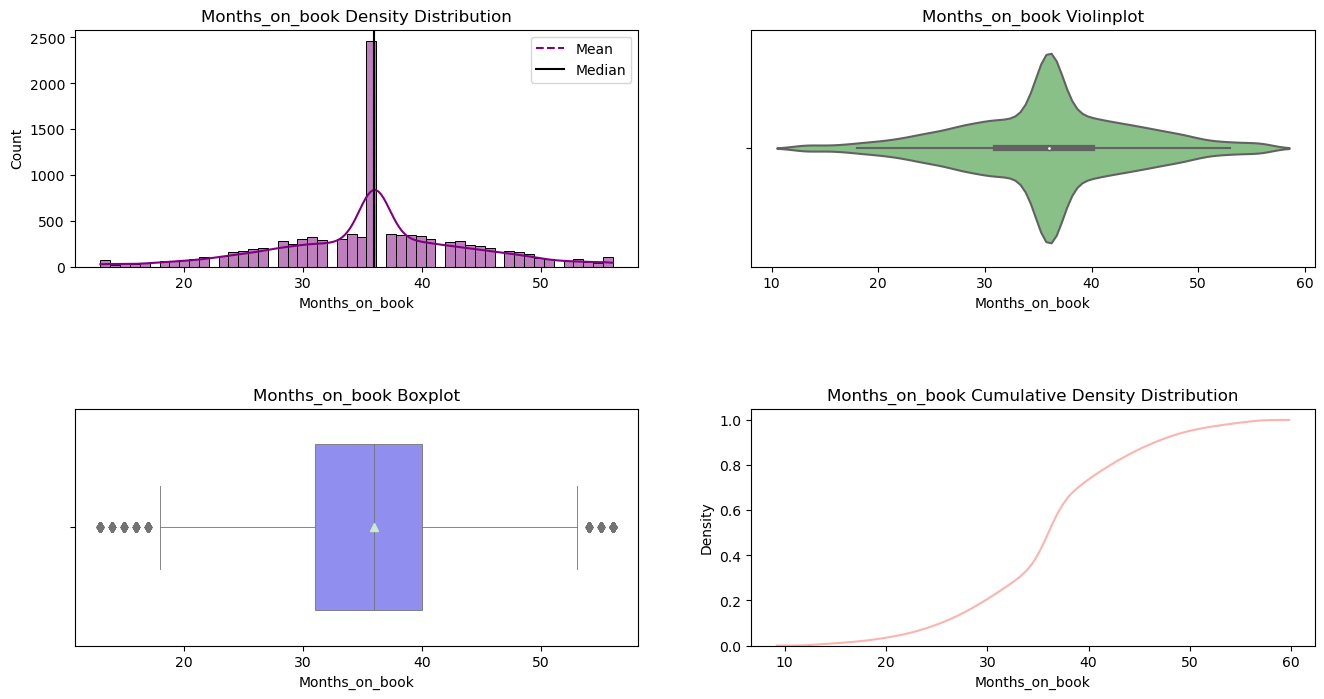

In [13]:
summary(data, "Months_on_book")

5 Point Summary of Months_inactive_12_mon Attribute:

+-------+-------+------+------+------+-------+
|       |   Min |   Q1 |   Q2 |   Q3 |   Max |
|-------+-------+------+------+------+-------|
| Value |     0 |    2 |    2 |    3 |     6 |
+-------+-------+------+------+------+-------+


/Users/chuchu/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chuchu/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


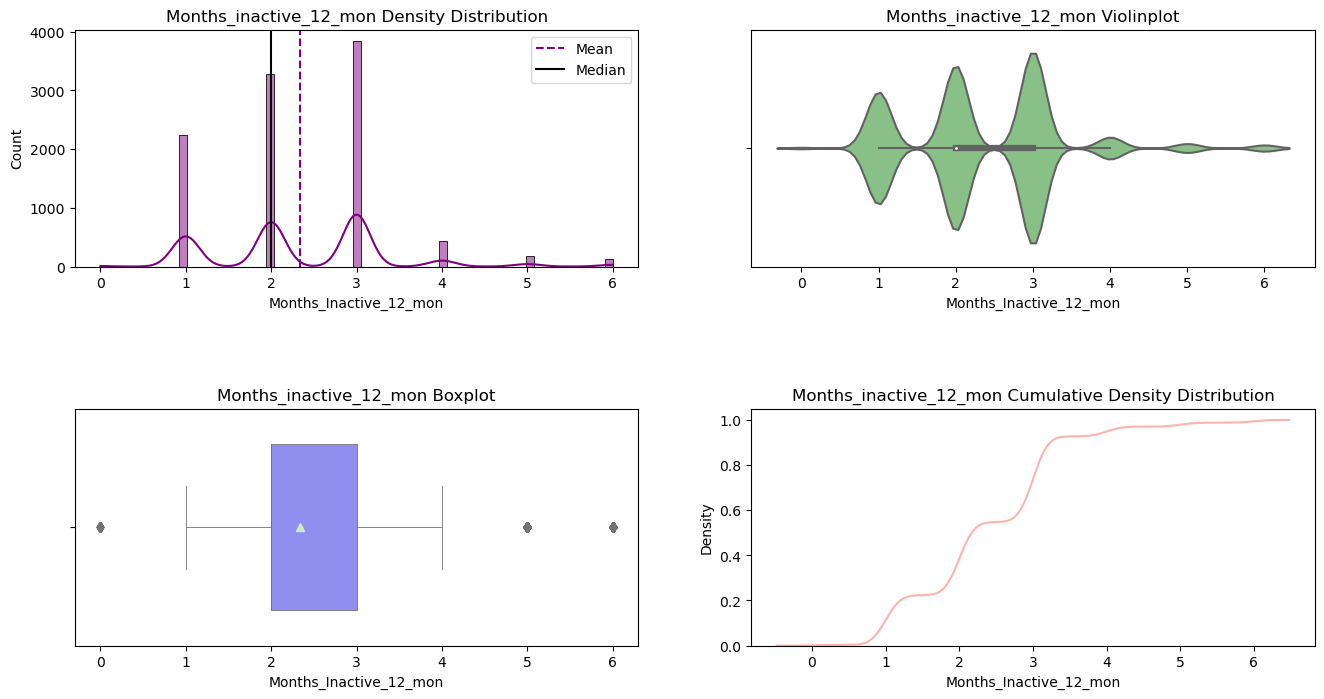

In [14]:
summary(data, "Months_Inactive_12_mon")

5 Point Summary of Credit_limit Attribute:

+-------+--------+------+------+---------+-------+
|       |    Min |   Q1 |   Q2 |      Q3 |   Max |
|-------+--------+------+------+---------+-------|
| Value | 1438.3 | 2555 | 4549 | 11067.5 | 34516 |
+-------+--------+------+------+---------+-------+


/Users/chuchu/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chuchu/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


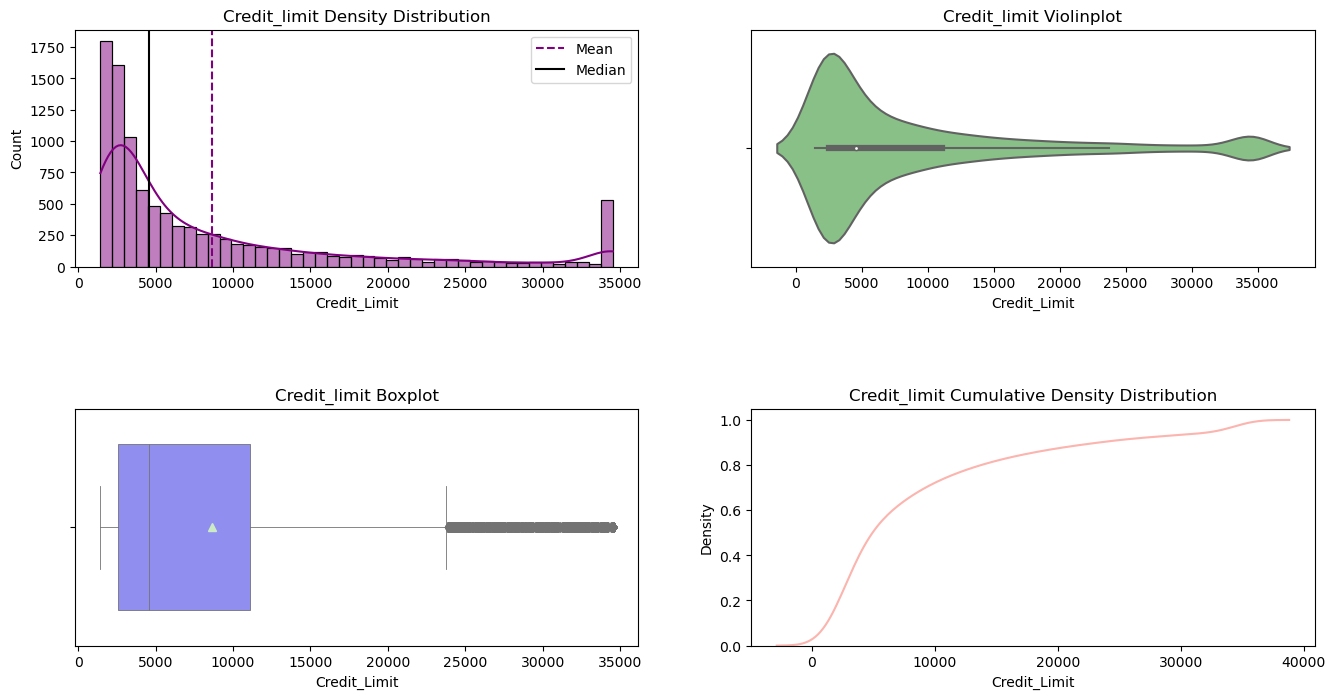

In [15]:
summary(data, "Credit_Limit")

In [16]:
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib import figure



/var/folders/3v/bzrh0wc57bn90x31h169xt700000gn/T/ipykernel_15297/779878519.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data.loc[:, ~data.columns.isin(['CLIENTNUM', "Attrition_Flag"])].hist(ax = ax)
/var/folders/3v/bzrh0wc57bn90x31h169xt700000gn/T/ipykernel_15297/779878519.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


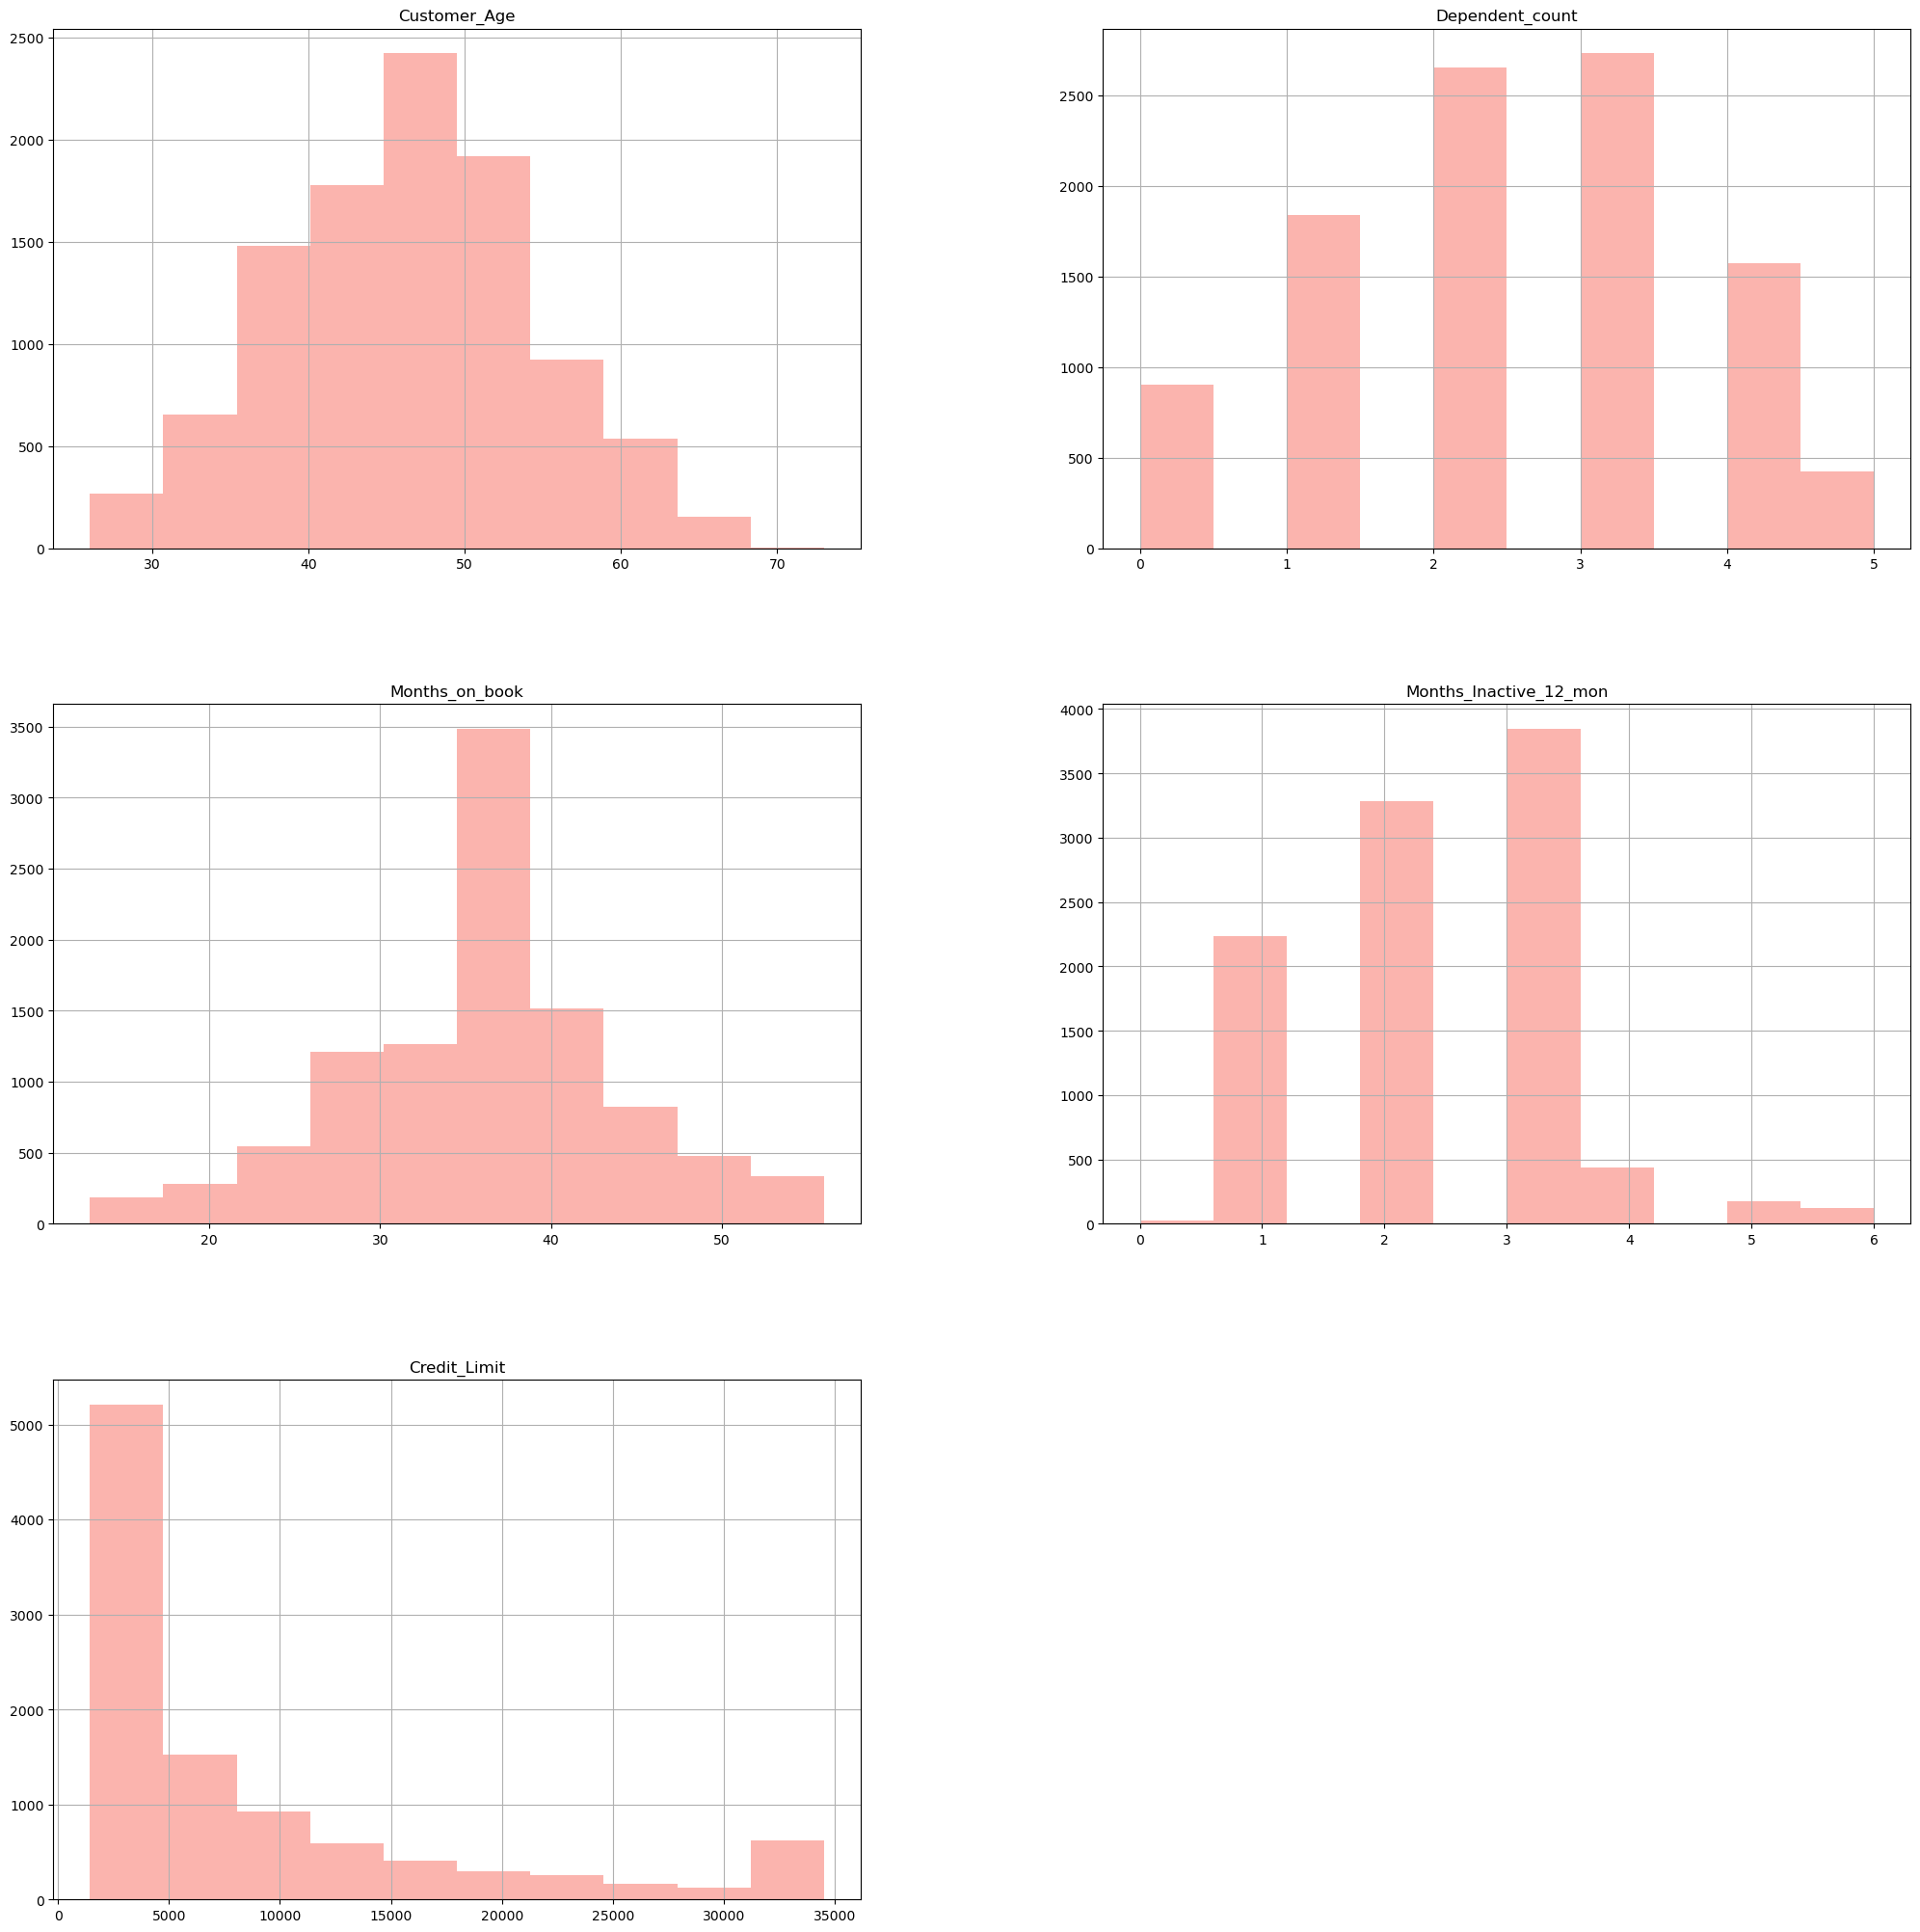

In [17]:
fig = plt.figure(figsize = (20,20))
ax = fig.gca()
plt.tight_layout()
data.loc[:, ~data.columns.isin(['CLIENTNUM', "Attrition_Flag"])].hist(ax = ax)
fig.show()

In [18]:
data['Attrition_Flag'] = data.Attrition_Flag.map({'Attrited Customer': 1,
                                               'Existing Customer': 0})
data

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,0,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914,1.335,1144,42,1.625,0.061
1,818770008,0,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392,1.541,1291,33,3.714,0.105
2,713982108,0,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418,2.594,1887,20,2.333,0
3,769911858,0,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796,1.405,1171,20,2.333,0.76
4,709106358,0,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716,2.175,816,28,2.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,0,50,M,2,Graduate,Single,$40K - $60K,Blue,40,...,2,3,4003.0,1851,2152,0.703,15476,117,0.857,0.462
10123,710638233,1,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,...,2,3,4277.0,2186,2091,0.804,8764,69,0.683,0.511
10124,716506083,1,44,F,1,High School,Married,Less than $40K,Blue,36,...,3,4,5409.0,0,5409,0.819,10291,60,0.818,0
10125,717406983,1,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,...,3,3,5281.0,0,5281,0.535,8395,62,0.722,0


In [19]:
data["Attrition_Flag"].value_counts()

Attrition_Flag
0    8500
1    1627
Name: count, dtype: int64

In [20]:
data['Months_Inactive_12_mon']

0        1
1        1
2        1
3        4
4        1
        ..
10122    2
10123    2
10124    3
10125    3
10126    2
Name: Months_Inactive_12_mon, Length: 10127, dtype: int64

In [21]:
cross_tab = pd.crosstab(index= data['Income_Category'],
                        columns= data ['Attrition_Flag'])

cross_tab_prop = pd.crosstab(index= data ['Income_Category'],
                        columns= data ['Attrition_Flag'],
                             normalize="index")
cross_tab_prop

Attrition_Flag,0,1
Income_Category,,
$120K +,0.826685,0.173315
$40K - $60K,0.848603,0.151397
$60K - $80K,0.865193,0.134807
$80K - $120K,0.842345,0.157655
Less than $40K,0.828138,0.171862
Unknown,0.831835,0.168165


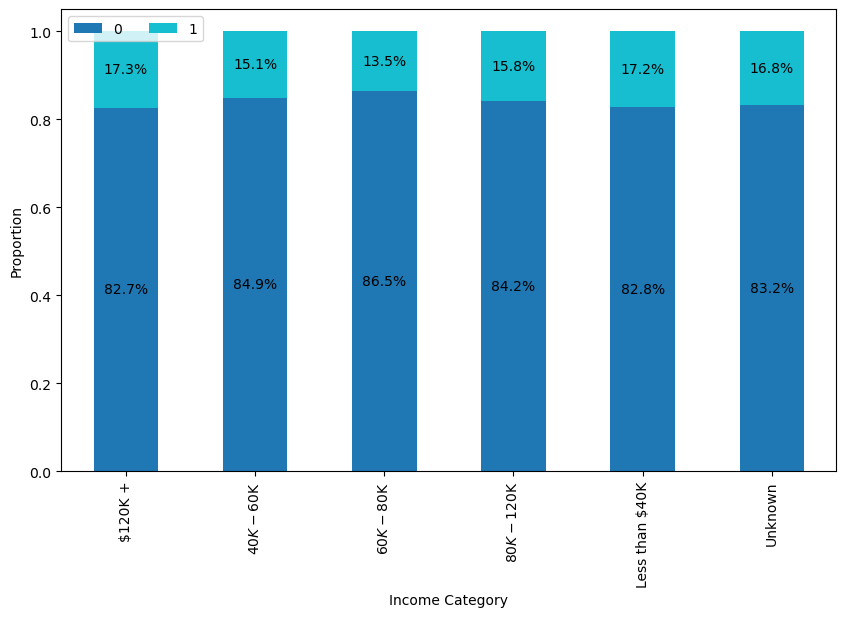

In [22]:
ax = cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Income Category")
plt.ylabel("Proportion")


for c in ax.containers:

    labels = [f'{np.round(v.get_height() * 100, 1)}%' if v.get_height() > 0 else '' for v in c]
    
    ax.bar_label(c, labels=labels, label_type='center')

plt.show()

<Axes: xlabel='Attrition_Flag', ylabel='Months_Inactive_12_mon'>

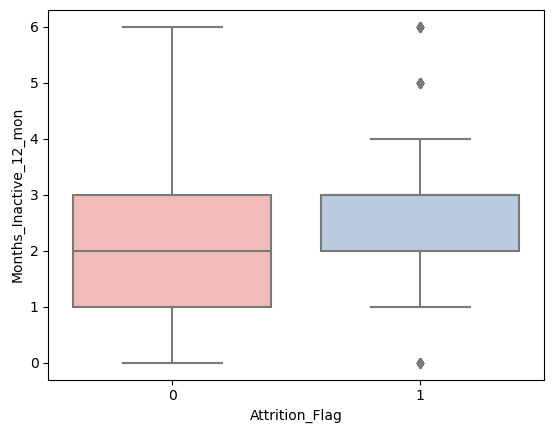

In [23]:
sns.boxplot(x='Attrition_Flag', y='Months_Inactive_12_mon', data = data)

<Axes: xlabel='Attrition_Flag', ylabel='Months_on_book'>

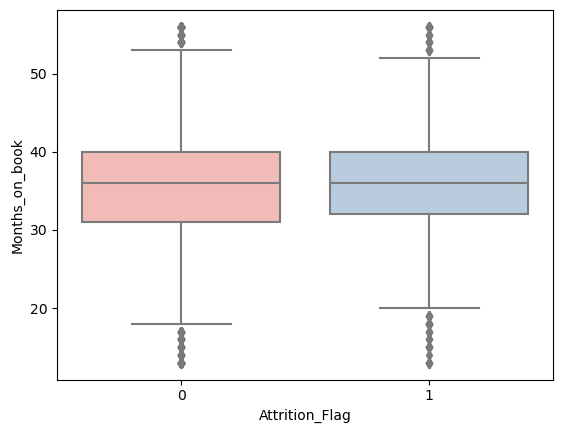

In [24]:
sns.boxplot(x='Attrition_Flag', y='Months_on_book', data = data)

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Categorical features:
Index(['Gender', 'Education_Level', 'Marital_Status', 'Income_Category',
       'Card_Category', 'Total_Relationship_Count', 'Contacts_Count_12_mon',
       'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1',
       'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1',
       'Avg_Utilization_Ratio'],
      dtype='object')
Numerical features:
Index(['Customer_Age', 'Dependent_count', 'Months_on_book',
       'Months_Inactive_12_mon', 'Credit_Limit'],
      dtype='object')
All feature names:
['Customer_Age' 'Dependent_count' 'Months_on_book' ...
 'Avg_Utilization_Ratio_0.994' 'Avg_Utilization_Ratio_0.995'
 'Avg_Utilization_Ratio_0.999']
Feature importances:
[1.46605427e-02 9.69403765e-03 1.48365204e-02 ... 2.59606409e-07
 6.69661976e-05 7.20522756e-05]
Top 10 most important features:
                          Feature  Importance
41          Total_Revolving_Bal_0    0.029674
15975     Avg_Utilization_Ratio_0    0.029442
4                    Credi

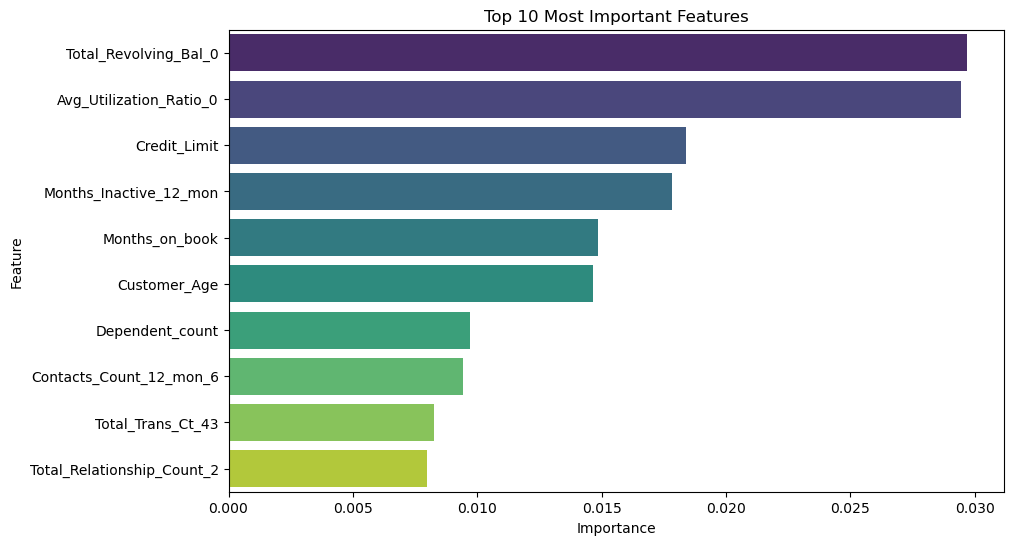

In [30]:


# Drop the CLIENTNUM column as it's an identifier
if 'CLIENTNUM' in data.columns:
    data = data.drop(columns=['CLIENTNUM'])

# Separate the target variable
target = 'Attrition_Flag'
if target not in data.columns:
    raise ValueError(f"Target column '{target}' is not in the dataframe")

X = data.drop(columns=[target])
y = data[target]

# Identify categorical and numerical columns
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Print the identified categorical and numerical columns to debug
print("Categorical features:")
print(categorical_features)

print("Numerical features:")
print(numerical_features)

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the preprocessing and RandomForest pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Fit the pipeline to the data
rf_pipeline.fit(X, y)

# Get feature importances
feature_importances = rf_pipeline.named_steps['classifier'].feature_importances_

# Get feature names after preprocessing
encoded_feature_names = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numerical_features, encoded_feature_names])

# Print out the feature names and their importances to debug
print("All feature names:")
print(all_feature_names)

print("Feature importances:")
print(feature_importances)

# Create a DataFrame for feature importances
feature_importances_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importances})

# Sort by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Display the top 10 most important features
top_10_features = feature_importances_df.head(10)

# Print the top 10 most important features to debug
print("Top 10 most important features:")
print(top_10_features)

# Plot the top 10 most important features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_10_features, palette="viridis")
plt.title('Top 10 Most Important Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [39]:
top_10_features

,Feature,Importance
41,Total_Revolving_Bal_0,0.029674
15975,Avg_Utilization_Ratio_0,0.029442
4,Credit_Limit,0.018397
3,Months_Inactive_12_mon,0.017816
2,Months_on_book,0.014837
0,Customer_Age,0.014661
1,Dependent_count,0.009694
40,Contacts_Count_12_mon_6,0.009439
15088,Total_Trans_Ct_43,0.008246
29,Total_Relationship_Count_2,0.007993


In [42]:
# Step 2: Select Specific Columns
selected_columns = [
    'Credit_Limit', 'Avg_Utilization_Ratio', 'Months_Inactive_12_mon', 'Months_on_book',
    'Contacts_Count_12_mon', 'Customer_Age', 'Total_Revolving_Bal', 
    'Dependent_count', 'Total_Trans_Ct', 'Total_Relationship_Count'
]

X = data[selected_columns]

y = data['Attrition_Flag']

# Identify categorical and numerical columns
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Step 3: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Create and Train the Model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(random_state=42))])

# Fit the model
model.fit(X_train, y_train)

# Step 5: Evaluate the Model
y_pred = model.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('Classification Report:')
print(classification_report(y_test, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.88
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.94      2543
           1       0.89      0.33      0.49       496

    accuracy                           0.88      3039
   macro avg       0.89      0.66      0.71      3039
weighted avg       0.89      0.88      0.86      3039

Confusion Matrix:
[[2523   20]
 [ 330  166]]


In [44]:
# Top 5
selected_columns = [
    'Credit_Limit', 'Avg_Utilization_Ratio', 'Months_Inactive_12_mon', 'Months_on_book'
]

X = data[selected_columns]

y = data['Attrition_Flag']

# Identify categorical and numerical columns
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Step 3: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Create and Train the Model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(random_state=42))])

# Fit the model
model.fit(X_train, y_train)

# Step 5: Evaluate the Model
y_pred = model.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('Classification Report:')
print(classification_report(y_test, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.83
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      2543
           1       0.43      0.22      0.29       496

    accuracy                           0.83      3039
   macro avg       0.65      0.58      0.60      3039
weighted avg       0.79      0.83      0.80      3039

Confusion Matrix:
[[2399  144]
 [ 387  109]]


In [52]:
selected_columns = [
    'Credit_Limit', 'Total_Revolving_Bal', 'Total_Amt_Chng_Q4_Q1', 'Total_Ct_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Avg_Utilization_Ratio'
]

X = data[selected_columns]

y = data['Attrition_Flag']

# Identify categorical and numerical columns
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Step 3: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Create and Train the Model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(random_state=42))])

# Fit the model
model.fit(X_train, y_train)

# Step 5: Evaluate the Model
y_pred = model.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('Classification Report:')
print(classification_report(y_test, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.87
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      2543
           1       0.77      0.29      0.42       496

    accuracy                           0.87      3039
   macro avg       0.82      0.63      0.67      3039
weighted avg       0.86      0.87      0.84      3039

Confusion Matrix:
[[2500   43]
 [ 354  142]]


In [59]:
# Class weight adjustment 
selected_columns = [
    'Credit_Limit', 'Avg_Utilization_Ratio', 'Months_Inactive_12_mon', 'Months_on_book',
    'Contacts_Count_12_mon', 'Customer_Age', 'Total_Revolving_Bal', 
    'Dependent_count', 'Total_Trans_Ct', 'Total_Relationship_Count'
]

X = data[selected_columns]
y = data['Attrition_Flag']

# Identify categorical and numerical columns
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

class_weights = {0: 1, 1: 20} 

# Create RandomForestClassifier with balanced class weights
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(class_weight= class_weights, random_state=42))])

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('Classification Report:')
print(classification_report(y_test, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.89
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      2543
           1       0.85      0.38      0.52       496

    accuracy                           0.89      3039
   macro avg       0.87      0.68      0.73      3039
weighted avg       0.88      0.89      0.87      3039

Confusion Matrix:
[[2509   34]
 [ 310  186]]


In [60]:
# confusion matrix


from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[2509   34]
 [ 310  186]]


In [66]:
from sklearn.utils import resample

In [68]:
# Separate majority and minority classes
majority_class = data[data['Attrition_Flag'] == 0]
minority_class = data[data['Attrition_Flag'] == 1]

# Upsample the minority class
upsampled_minority = resample(minority_class, replace=True, n_samples=len(majority_class), random_state=42)

# Combine the upsampled data with the original majority class
balanced_data = pd.concat([majority_class, upsampled_minority])

In [69]:
# Step 2: Select Specific Columns
selected_columns = [
    'Credit_Limit', 'Avg_Utilization_Ratio', 'Months_Inactive_12_mon', 'Months_on_book',
    'Contacts_Count_12_mon', 'Customer_Age', 'Total_Revolving_Bal', 
    'Dependent_count', 'Total_Trans_Ct', 'Total_Relationship_Count'
]

X = balanced_data[selected_columns]

y = balanced_data['Attrition_Flag']

# Identify categorical and numerical columns
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Step 3: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Create and Train the Model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(random_state=42))])

# Fit the model
model.fit(X_train, y_train)

# Step 5: Evaluate the Model
y_pred = model.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('Classification Report:')
print(classification_report(y_test, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.97
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      2568
           1       0.96      0.99      0.97      2532

    accuracy                           0.97      5100
   macro avg       0.97      0.97      0.97      5100
weighted avg       0.97      0.97      0.97      5100

Confusion Matrix:
[[2453  115]
 [  25 2507]]


In [ ]:

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD

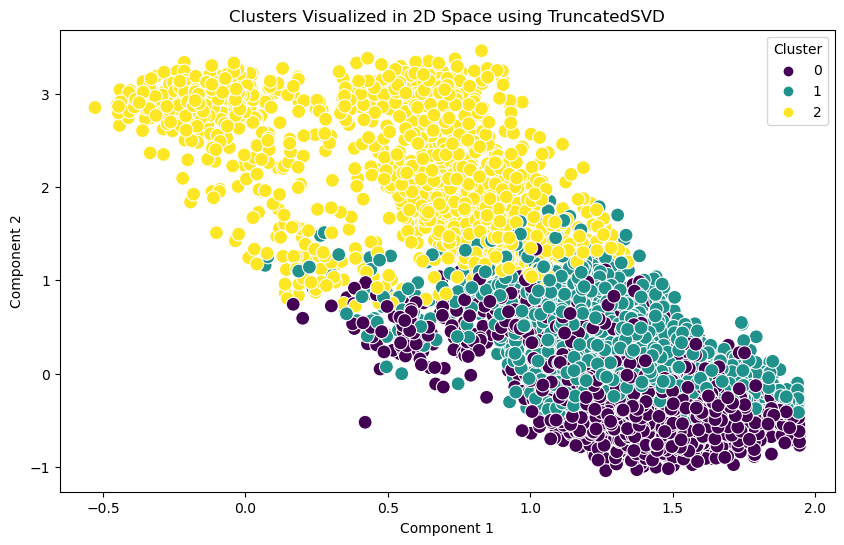

In [ ]:
# # Step 2: Preprocess the Data

# # Separate features from target variable if needed, but for clustering we'll use all features
# selected_columns = [
#     'Education_Level', 'Income_Category', 'Card_Category', 'Months_on_book',
#     'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
#     'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1'
# ]
# X = data[selected_columns]


# # Identify categorical and numerical columns
# categorical_features = X.select_dtypes(include=['object']).columns
# numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# # Preprocessing for numerical data
# numerical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='median')),
#     ('scaler', StandardScaler())
# ])

# # Preprocessing for categorical data
# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

# # Bundle preprocessing for numerical and categorical data
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numerical_features),
#         ('cat', categorical_transformer, categorical_features)
#     ])

# # Step 3: Apply K-means Clustering
# # Define the preprocessing and K-means pipeline
# kmeans_pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('kmeans', KMeans(n_clusters=3, random_state=42))
# ])

# # Fit the pipeline to the data
# kmeans_pipeline.fit(X)

# # Get cluster labels
# clusters = kmeans_pipeline.named_steps['kmeans'].labels_

# # Add cluster labels to the original data
# data['Cluster'] = clusters

# # Step 4: Visualize the Clusters using TruncatedSVD

# # Reduce dimensionality for visualization purposes
# svd = TruncatedSVD(n_components=2)
# X_reduced = svd.fit_transform(preprocessor.fit_transform(X))

# # Create a DataFrame with reduced dimensions
# df_reduced = pd.DataFrame(X_reduced, columns=['Component 1', 'Component 2'])
# df_reduced['Cluster'] = clusters

# # Plot the clusters
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='Component 1', y='Component 2', hue='Cluster', data=df_reduced, palette='viridis', s=100)
# plt.title('Clusters Visualized in 2D Space using TruncatedSVD')
# plt.show()